# CE-40959: Advanced Machine Learning
## HW2 - Optimization-based Meta Learning (100 points)


In this notebook, you are going to implement a optimization-based meta learner using the `Omniglot` dataset.

Please write your code in specified sections and do not change anything else. If you have a question regarding this homework, please ask it on the Quera.

Also, it is recommended to use Google Colab to do this homework. You can connect to your drive using the code below:

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Import Required libraries

In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
import torch
import torchvision
import random
import torch.nn as nn
import math
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.optim as optim
import torch.utils.data as data
from copy import deepcopy
import pickle
from tqdm.auto import tqdm

## Introduction

In Meta-Learning literature and in the meta-training phase, you are given some batches which consist of `support` and `query` sets. you train your model in a way that by using a support set you could predict query set labels correctly.

The pioneer of this branch is Model-Agnostic Meta-Learning(MAML). 

First, we should build the dataset in this way that each batch returns N*(k+k') images. `k` is the number of support images per class and `k'` is the number of query images per class in a batch.

The Omniglot data set is designed for developing more human-like learning algorithms. It contains 1623 different handwritten characters from 50 different alphabets. Each of the 1623 characters was drawn online via Amazon's Mechanical Turk by 20 different people.

Train and test dataset contains 964 and 659 classes, respectively. Torchvision-based Omniglot dataset is ordered and every 20 images in a row belong to one class.

In [12]:
# Meta learning parameters.

N = 5
support_size = 1
query_size = 15
meta_inner_lr = 0.4
meta_outer_lr = 0.001

## Prepare dataset (5 points)

In [3]:
transform = transforms.Compose([
    transforms.Resize(28),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])

train_dataset = torchvision.datasets.Omniglot('./data/omniglot/', download = True, background = True, transform = transform)
test_dataset = torchvision.datasets.Omniglot('./data/omniglot/', download = True, background = False, transform = transform)

train_labels = np.repeat(np.arange(964), 20)
test_labels = np.repeat(np.arange(659), 20)

Files already downloaded and verified
Files already downloaded and verified


To build a dataloader, we should have a class that yields indexes of selected data in the dataset for every iteration and pass it to the `batch_sampler` attribute of dataloader.

Complete below code based on this pseudocode:


1.   select `N` classes randomly from all classes
2.   select `support_size + query_size` images from each classes independently and randomly
3.   shuffle dataset indexes, but don't forget to put query indexes at the last of the list

In [4]:
class BatchSampler(object):
    '''
    BatchSampler: yield a batch of indexes at each iteration.
    __len__ returns the number of episodes per epoch (same as 'self.iterations').
    '''

    def __init__(self, labels, classes_per_it, num_samples_support, num_samples_query, iterations, batch_size):
        '''
        Initialize the BatchSampler object
        Args:
        - labels: array of labels of dataset.
        - classes_per_it: number of random classes for each iteration
        - num_samples: number of samples for each iteration for each class
        - iterations: number of iterations (episodes) per epoch
        - batch_size: number of batches per iteration
        '''
        super(BatchSampler, self).__init__()
        self.labels = labels
        self.classes_per_it = classes_per_it
        self.supports_per_class = num_samples_support
        self.queries_per_class = num_samples_query
        self.iterations = iterations
        self.batch_size = batch_size
        self.classes = np.unique(self.labels)

    def __iter__(self):
        '''
        yield a batch of indexes
        '''
        S = self.supports_per_class
        Q = self.queries_per_class

        for it in range(self.iterations):
            total_batch_indexes = np.array([])
            #################################################################################
            #                  COMPLETE THE FOLLOWING SECTION (5 points)                    #
            #################################################################################
            # feel free to add/edit initialization part of sampler.
            #################################################################################
            for b in range(self.batch_size):
              batch = np.array([])
              random_classes = np.random.choice(self.classes, self.classes_per_it, False)
              num_samples = S + Q
              support_indexes = np.zeros(self.classes_per_it * S)
              query_indexes = np.zeros(self.classes_per_it * Q)

              for i, c in enumerate(random_classes):
                  random_indices = np.random.randint(20*c, 20*c+20, size=num_samples)
                  support_indexes[i * S : (i+1) * S] = random_indices[:S]
                  query_indexes[i * Q : (i+1) * Q] = random_indices[S:]

              np.random.shuffle(support_indexes) 
              np.random.shuffle(query_indexes) 
              support_indexes = support_indexes.astype(int)
              query_indexes = query_indexes.astype(int)
              batch = np.concatenate((support_indexes, query_indexes))
              total_batch_indexes = np.concatenate((total_batch_indexes, batch))
   
            #################################################################################
            #                                   THE END                                     #
            #################################################################################

            yield total_batch_indexes.astype(int)
    def __len__(self):
        return self.iterations

In [13]:
iterations = 5000
batch_size = 32

train_sampler = BatchSampler(labels=train_labels, classes_per_it=N,
                              num_samples_support= support_size ,num_samples_query= query_size, iterations=iterations,
                              batch_size=batch_size)

test_sampler = BatchSampler(labels=test_labels, classes_per_it=N,
                              num_samples_support= support_size ,num_samples_query= query_size, iterations=iterations,
                              batch_size=batch_size)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_sampler=train_sampler)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_sampler=test_sampler)

## Model (45 points)

Let's Build our model. the whole model is `ProtoNet` feature extractor which is used in [Prototypical Network paper](https://arxiv.org/abs/1703.05175) but due to the lack of enough computational resources for first part of question, we give you some part of the network as pretraining and only you will do meta-training on the last layer of the network.

In [6]:
def conv_block(in_channels, out_channels):
    return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels, momentum=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

class Feature_extractor(nn.Module):
    '''
    source: https://github.com/jakesnell/prototypical-networks/blob/f0c48808e496989d01db59f86d4449d7aee9ab0c/protonets/models/few_shot.py#L62-L84
    '''
    def __init__(self, x_dim=1, hid_dim=64):
        super(Feature_extractor, self).__init__()
        self.encoder = nn.Sequential(
            conv_block(x_dim, hid_dim),
            conv_block(hid_dim, hid_dim),
            conv_block(hid_dim, hid_dim)
        )

    def forward(self, x):
        return self.encoder(x)

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
feature_extractor = Feature_extractor()
feature_extractor = feature_extractor.to(device)
feature_extractor.load_state_dict(torch.load('/content/drive/MyDrive/MSC1400_1/AML/HW2/Practical/pretrained_model.pt', map_location=device))

<All keys matched successfully>

To be specific, you are going to get the features of each image via the feature extraction network and give the output of that as input to your meta-learner. at the end of initialization, you should have initialized your network parameters and have saved them on the given ParameterList for future forward passes.

The `Learner` class is a module that initializes your meta-parameters based on your given config as input. the format of config is arbitrary and you should prepare required parameters for initializing your submodules. do a quick look at the modules of meta-network to implement your Learner class.

At forwarding pass, you give your input and two optional attributes.

1.   **vars**: the default value of this attribute is None and it means that meta-learner will use its own parameters for forwarding pass, but you can give your desired parameters for computing output
2.   **bn_training**: if True, batch normalization layers show the same behavior as training time.


In the `zero_grad` method, you are going to set the gradient of given parameters as attribute or class parameters (self.vars) to zero.





In [8]:
class Learner(nn.Module):

    def __init__(self, *args, **kwargs):
        super(Learner, self).__init__()

        # this dict contains all tensors needed to be optimized
        self.vars = nn.ParameterList()
        # running_mean and running_var
        self.vars_bn = nn.ParameterList()

        self.config =  kwargs['config']
        self.f_e = kwargs['fe'] #if true this means that the meta parameters are just the last layer's parameters else the whole pretrained network+lastlayer is the metalearner
        self.device = kwargs['device'] 

        #################################################################################
        #                  COMPLETE THE FOLLOWING SECTION (10 points)                   #
        #################################################################################
        # initialize your meta-network parameters based on given config.
        #################################################################################

        for i, (name, param) in enumerate(self.config):

            if name is 'conv2d':
                w = nn.Parameter(torch.ones(*param[:4]))
                torch.nn.init.kaiming_normal_(w)
                self.vars.append(w)
                self.vars.append(nn.Parameter(torch.zeros(param[0])))

            elif name is 'linear':
                w = nn.Parameter(torch.ones(*param))
                torch.nn.init.kaiming_normal_(w)
                self.vars.append(w)
                self.vars.append(nn.Parameter(torch.zeros(param[0])))

            elif name is 'bn':
                w = nn.Parameter(torch.ones(param[0]))
                self.vars.append(w)
                self.vars.append(nn.Parameter(torch.zeros(param[0])))

                running_mean = nn.Parameter(torch.zeros(param[0]), requires_grad=False)
                running_var = nn.Parameter(torch.ones(param[0]), requires_grad=False)
                self.vars_bn.extend([running_mean, running_var])
                self.vars.to(device)
                self.vars_bn.to(device)

            elif name in ['relu', 'max_pool2d','flatten']:
                continue
            else:
                raise NotImplementedError

        #################################################################################
        #                                   THE END                                     #
        #################################################################################


    def forward(self, x, vars=None, bn_training=True,Fe=False):

        #################################################################################
        #                  COMPLETE THE FOLLOWING SECTION (10 points)                   #
        #################################################################################
        # compute output of input with given parameters or class parameters
        #################################################################################

        if vars is None:
            vars = self.vars

        idx = 0
        bn_idx = 0
        if self.f_e:
          x = feature_extractor(x)

        for name, param in self.config:
            if name is 'conv2d':
                w, b = vars[idx], vars[idx + 1]
                x = F.conv2d(x, w, b, stride=param[4], padding=param[5])
                idx += 2
            
            elif name is 'linear':
                w, b = vars[idx], vars[idx + 1]
                x = F.linear(x, w, b)
                idx += 2

            elif name is 'bn':
                w, b = vars[idx], vars[idx + 1]
                running_mean, running_var = self.vars_bn[bn_idx], self.vars_bn[bn_idx+1]
                x = F.batch_norm(x, running_mean, running_var, weight=w, bias=b, training=bn_training)
                idx += 2
                bn_idx += 2

            elif name is 'flatten':
                x = x.view(x.size(0), -1)

            elif name is 'relu':
                x = F.relu(x, inplace=param[0])
            
            elif name is 'max_pool2d':
                x = F.max_pool2d(x, param[0], param[1], param[2])
           
            else:
                raise NotImplementedError

        assert idx == len(vars)
        assert bn_idx == len(self.vars_bn)
        return x

        #################################################################################
        #                                   THE END                                     #
        #################################################################################


    def zero_grad(self, vars=None):

        #################################################################################
        #                  COMPLETE THE FOLLOWING SECTION (5 points)                    #
        #################################################################################
        # set gradient of given parameters as attribute or class parameters to zero
        #################################################################################
        with torch.no_grad():
            if vars is not None:
                for param in vars:
                    if param.grad is not None:
                        param.grad.zero_()
            else:
                for param in self.vars:
                    if param.grad is not None:
                        param.grad.zero_()
        #################################################################################
        #                                   THE END                                     #
        #################################################################################

    def parameters(self):
        return self.vars

Now at the `Meta` module, you implement your meta-learner module. you give your all support and query data to your module and the model will update your `Learner` parameters based on MAML-loss.
to clarify, you pass your support data to `Learner` and then calculate the loss on them and update your parameters and then continue to update your parameters based on the given number of inner-loop updates and finally calculate the loss on query data and update `Learner` parameters

In [22]:
class Meta(nn.Module):
    def __init__(self, *args, **kwargs):

        super(Meta, self).__init__()

        #################################################################################
        #                  COMPLETE THE FOLLOWING SECTION (5 points)                   #
        #################################################################################
        # initialize your meta-learner
        #################################################################################
        self.update_lr = kwargs['update_lr']
        self.meta_lr = kwargs['meta_lr']
        self.n_way = kwargs['n_way']
        self.k_spt = kwargs['k_spt']
        self.k_qry = kwargs['k_qry']
        self.update_step = kwargs['update_step']
        self.update_step_test = kwargs['update_step_test']
        self.net = Learner(config=kwargs['config'],fe=kwargs['fe'],device=kwargs['device'])
        self.meta_optim = optim.Adam(self.net.parameters(), lr=self.meta_lr)

        #################################################################################
        #                                   THE END                                     #
        #################################################################################


    def forward(self, x_spt, y_spt, x_qry, y_qry):

        #################################################################################
        #                  COMPLETE THE FOLLOWING SECTION (15 points)                   #
        #################################################################################
        # meta-train your parameters.
        #################################################################################

        task_num, setsz, c_, h, w = x_spt.size()
        querysz = x_qry.size(1)

        losses_q = [0 for _ in range(self.update_step + 1)]  # losses_q[i] is the loss on step i
        corrects = [0 for _ in range(self.update_step + 1)]


        for i in range(task_num):
            logits = self.net(x_spt[i], vars=None, bn_training=True)
            loss = F.cross_entropy(logits, y_spt[i])
            grad = torch.autograd.grad(loss, self.net.parameters())
            fast_weights = list(map(lambda p: p[1] - self.update_lr * p[0], zip(grad, self.net.parameters())))

            with torch.no_grad():
                logits_q = self.net(x_qry[i], self.net.parameters(), bn_training=True)
                loss_q = F.cross_entropy(logits_q, y_qry[i])
                losses_q[0] += loss_q

                pred_q = F.softmax(logits_q, dim=1).argmax(dim=1)
                correct = torch.eq(pred_q, y_qry[i]).sum().item()
                corrects[0] = corrects[0] + correct

            with torch.no_grad():
                logits_q = self.net(x_qry[i], fast_weights, bn_training=True)
                loss_q = F.cross_entropy(logits_q, y_qry[i])
                losses_q[1] += loss_q
                pred_q = F.softmax(logits_q, dim=1).argmax(dim=1)
                correct = torch.eq(pred_q, y_qry[i]).sum().item()
                corrects[1] = corrects[1] + correct

            for k in range(1, self.update_step):
                logits = self.net(x_spt[i], fast_weights, bn_training=True)
                loss = F.cross_entropy(logits, y_spt[i])
                grad = torch.autograd.grad(loss, fast_weights)
                fast_weights = list(map(lambda p: p[1] - self.update_lr * p[0], zip(grad, fast_weights)))

                logits_q = self.net(x_qry[i], fast_weights, bn_training=True)
                loss_q = F.cross_entropy(logits_q, y_qry[i])
                losses_q[k + 1] += loss_q

                with torch.no_grad():
                    pred_q = F.softmax(logits_q, dim=1).argmax(dim=1)
                    correct = torch.eq(pred_q, y_qry[i]).sum().item()  # convert to numpy
                    corrects[k + 1] = corrects[k + 1] + correct


        torch.save(self.net.state_dict(), '/content/drive/MyDrive/MSC1400_1/AML/HW2/Practical/model4.pt')
        loss_q = losses_q[-1] / task_num
        self.meta_optim.zero_grad()
        loss_q.requires_grad = True
        loss_q.backward()
        self.meta_optim.step()

        accs = np.array(corrects) / (querysz * task_num)
      
        return accs



        #################################################################################
        #                                   THE END                                     #
        #################################################################################


    def finetunning(self, x_spt, y_spt, x_qry, y_qry):
      
        assert len(x_spt.shape) == 4

        querysz = x_qry.shape[0]

        corrects = [0 for _ in range(self.update_step_test + 1)]

        # in order to not ruin the state of running_mean/variance and bn_weight/bias
        # we finetunning on the copied model instead of self.net
        net = deepcopy(self.net)

        logits = net(x_spt)
        loss = F.cross_entropy(logits, y_spt)
        grad = torch.autograd.grad(loss, net.parameters())
        fast_weights = list(map(lambda p: p[1] - self.update_lr * p[0], zip(grad, net.parameters())))

        with torch.no_grad():
            logits_q = net(x_qry, net.parameters(), bn_training=True)
            pred_q = F.softmax(logits_q, dim=1).argmax(dim=1)
            correct = torch.eq(pred_q, y_qry).sum().item()
            corrects[0] = corrects[0] + correct

        with torch.no_grad():
            logits_q = net(x_qry, fast_weights, bn_training=True)
            pred_q = F.softmax(logits_q, dim=1).argmax(dim=1)
            correct = torch.eq(pred_q, y_qry).sum().item()
            corrects[1] = corrects[1] + correct

        for k in range(1, self.update_step_test):
            logits = net(x_spt, fast_weights, bn_training=True)
            loss = F.cross_entropy(logits, y_spt)
            grad = torch.autograd.grad(loss, fast_weights)
            fast_weights = list(map(lambda p: p[1] - self.update_lr * p[0], zip(grad, fast_weights)))

            logits_q = net(x_qry, fast_weights, bn_training=True)
            loss_q = F.cross_entropy(logits_q, y_qry)

            with torch.no_grad():
                pred_q = F.softmax(logits_q, dim=1).argmax(dim=1)
                correct = torch.eq(pred_q, y_qry).sum().item()  
                corrects[k + 1] = corrects[k + 1] + correct
        del net
        accs = np.array(corrects) / querysz

        return accs


## With Feature Extractor

Your Meta-network which you are going to initialize your Learner based on it for first part of question is as follows:


1.   **Conv2d layer**: in_channels=64, out_channels:64, kernel_size=3, stride=1, padding=1
2.   **BatchNorm2D layer**: out_channels=64
3.   **ReLU activation**
4.   **Max Pooling layer**: kernel_size = 2, stride = 2
5.   **Flatten layer**
6.   **Linear layer**: in_features=64, out_features=N (number of classes in meta-learning)




Meta-train **three** different networks with three different inner loop updates=[1, 2, 3]. after some reasonable epochs, plot accuracy of meta-test phase based on inner loop update parameter on each network.

### Train (25 points)

In [10]:
def map_labels(labels,size):
       for i in range (0,len(labels),size):
          true_labels = set(labels[i:i+size].tolist())
          map = {}
          for j, l in enumerate(true_labels):
            map[l] = j
          for j in range (size):
            labels[i+j] = map[labels[i+j].item()]
          return labels

در این قسمت سه بار عملیات ترین برای تعداد تکرارهای ۱و۲و۳ برای حلقه داخلی انجام شده است و در هر سه بار به تعداد ۲۰۰۰ ایپاک ران شده است که در زیر خروجی های هزار ایپاک آخر هرکدام را مشاهده میکنیم (با توجه به محدودیت زمان به تعداد بیشتر ران نکردیم)

# Update Step 1

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#################################################################################
#                  COMPLETE THE FOLLOWING SECTION (25 points)                   #
#################################################################################
# Define your config and initialize model and parameters
# prepare your data as input to your model.
# train meta-network
# get acurracy of model in meta-test phase
#################################################################################
epochs = 2000
config = [
        ('conv2d', [64, 64, 3, 3, 1, 1]),
        ('bn', [64]),
        ('relu', [True]),
        ('max_pool2d', [2,2,0]),
        ('flatten', []),
        ('linear', [N, 64])
    ]

maml = Meta(config=config,fe=True,update_lr=meta_inner_lr,meta_lr=meta_outer_lr,n_way=N,
            k_spt=support_size,k_qry=query_size,update_step=1,update_step_test=1,device=device).to(device)

tmp = filter(lambda x: x.requires_grad, maml.parameters())
num = sum(map(lambda x: np.prod(x.shape), tmp))
print(maml)
print('Total trainable tensors:', num)


for step in range(epochs+1):

    x,y = iter(train_dataloader).next()

    x_spt = np.empty(shape=(batch_size,N*support_size,1,28,28))
    x_qry = np.empty(shape=(batch_size,N*query_size,1,28,28))
    y_spt = np.empty(shape=(batch_size,N*support_size))
    y_qry = np.empty(shape=(batch_size,N*query_size))
    map_y_spt = np.empty(shape=(batch_size,N*support_size))
    map_y_qry = np.empty(shape=(batch_size,N*query_size))

    num = (support_size+query_size)*N

    for i in range(batch_size):
      x_spt[i]=x[i*(num):i*(num)+support_size*N]
      x_qry[i]=x[i*(num)+support_size*N:(i+1)*(num)]
      y_spt[i]=y[i*(num):i*(num)+support_size*N]
      y_qry[i]=y[i*(num)+support_size*N:(i+1)*(num)]
      map_y_spt[i] = map_labels(torch.from_numpy(y_spt[i]),N*support_size)
      map_y_qry[i] = map_labels(torch.from_numpy(y_qry[i]),N*query_size)
    x_spt, y_spt, x_qry, y_qry = torch.from_numpy(x_spt).to(device,dtype=torch.float), torch.from_numpy(y_spt).type(torch.LongTensor).to(device), \
                                        torch.from_numpy(x_qry).to(device,dtype=torch.float), torch.from_numpy(y_qry).type(torch.LongTensor).to(device)
    


    map_y_spt = torch.from_numpy(map_y_spt).type(torch.LongTensor).to(device)
    map_y_qry = torch.from_numpy(map_y_qry).type(torch.LongTensor).to(device)

    accs = maml(x_spt, map_y_spt, x_qry, map_y_qry)
    with open('/content/drive/MyDrive/MSC1400_1/AML/HW2/Practical/metatrain_1_acc.pickle', 'wb') as handle:
        pickle.dump(accs, handle, protocol=pickle.HIGHEST_PROTOCOL)

    if step % 50 == 0:
            print('step:', step, '\ttraining acc:', accs[-1])

    if step % 500 == 0:
            accs = []
            for _ in range(1000//batch_size):
              # test
              x,y = iter(test_dataloader).next()

              x_spt = np.empty(shape=(batch_size,N*support_size,1,28,28))
              x_qry = np.empty(shape=(batch_size,N*query_size,1,28,28))
              y_spt = np.empty(shape=(batch_size,N*support_size))
              y_qry = np.empty(shape=(batch_size,N*query_size))
              map_y_spt = np.empty(shape=(batch_size,N*support_size))
              map_y_qry = np.empty(shape=(batch_size,N*query_size))
              num = (support_size+query_size)*N

              for i in range(batch_size):
                x_spt[i]=x[i*(num):i*(num)+support_size*N]
                x_qry[i]=x[i*(num)+support_size*N:(i+1)*(num)]
                y_spt[i]=y[i*(num):i*(num)+support_size*N]
                y_qry[i]=y[i*(num)+support_size*N:(i+1)*(num)]
                map_y_spt[i] = map_labels(y_spt[i],N*support_size)
                map_y_qry[i] = map_labels(y_qry[i],N*query_size)
              x_spt, y_spt, x_qry, y_qry = torch.from_numpy(x_spt).to(device,dtype=torch.float), torch.from_numpy(y_spt).type(torch.LongTensor).to(device), \
                                        torch.from_numpy(x_qry).to(device,dtype=torch.float), torch.from_numpy(y_qry).type(torch.LongTensor).to(device)
    
              map_y_spt = torch.from_numpy(map_y_spt).type(torch.LongTensor).to(device)
              map_y_qry = torch.from_numpy(map_y_qry).type(torch.LongTensor).to(device)
              for x_spt_one, y_spt_one, x_qry_one, y_qry_one in zip(x_spt, map_y_spt, x_qry, map_y_qry):
                    test_acc = maml.finetunning(x_spt_one, y_spt_one, x_qry_one, y_qry_one)
                    accs.append( test_acc )

            accs = np.array(accs).mean(axis=0).astype(np.float16)
            with open('/content/drive/MyDrive/MSC1400_1/AML/HW2/Practical/metatest_1_acc.pickle', 'wb') as handle:
                pickle.dump(accs, handle, protocol=pickle.HIGHEST_PROTOCOL)

            print('Test acc:', accs[-1])

#################################################################################
#                                   THE END                                     #
#################################################################################


Meta(
  (net): Learner(
    (vars): ParameterList(
        (0): Parameter containing: [torch.cuda.FloatTensor of size 64x64x3x3 (GPU 0)]
        (1): Parameter containing: [torch.cuda.FloatTensor of size 64 (GPU 0)]
        (2): Parameter containing: [torch.cuda.FloatTensor of size 64 (GPU 0)]
        (3): Parameter containing: [torch.cuda.FloatTensor of size 64 (GPU 0)]
        (4): Parameter containing: [torch.cuda.FloatTensor of size 5x64 (GPU 0)]
        (5): Parameter containing: [torch.cuda.FloatTensor of size 5 (GPU 0)]
    )
    (vars_bn): ParameterList(
        (0): Parameter containing: [torch.cuda.FloatTensor of size 64 (GPU 0)]
        (1): Parameter containing: [torch.cuda.FloatTensor of size 64 (GPU 0)]
    )
  )
)
Total trainable tensors: 37381
step: 1050 	training acc: 0.525
step: 1100 	training acc: 0.5791666666666667
step: 1150 	training acc: 0.5454166666666667
step: 1200 	training acc: 0.53
step: 1250 	training acc: 0.5291666666666667
step: 1300 	training acc: 0.5104

# Update Step 2

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
epochs = 2000
config = [
        ('conv2d', [64, 64, 3, 3, 1, 1]),
        ('bn', [64]),
        ('relu', [True]),
        ('max_pool2d', [2,2,0]),
        ('flatten', []),
        ('linear', [N, 64])
    ]

# maml = Meta(config=config,fe=True,update_lr=meta_inner_lr,meta_lr=meta_outer_lr,n_way=N,
#             k_spt=support_size,k_qry=query_size,update_step=2,update_step_test=2,device=device).to(device)

tmp = filter(lambda x: x.requires_grad, maml.parameters())
num = sum(map(lambda x: np.prod(x.shape), tmp))
print(maml)
print('Total trainable tensors:', num)


for step in range(1001,epochs+1):

    x,y = iter(train_dataloader).next()

    x_spt = np.empty(shape=(batch_size,N*support_size,1,28,28))
    x_qry = np.empty(shape=(batch_size,N*query_size,1,28,28))
    y_spt = np.empty(shape=(batch_size,N*support_size))
    y_qry = np.empty(shape=(batch_size,N*query_size))
    map_y_spt = np.empty(shape=(batch_size,N*support_size))
    map_y_qry = np.empty(shape=(batch_size,N*query_size))

    num = (support_size+query_size)*N

    for i in range(batch_size):
      x_spt[i]=x[i*(num):i*(num)+support_size*N]
      x_qry[i]=x[i*(num)+support_size*N:(i+1)*(num)]
      y_spt[i]=y[i*(num):i*(num)+support_size*N]
      y_qry[i]=y[i*(num)+support_size*N:(i+1)*(num)]
      map_y_spt[i] = map_labels(torch.from_numpy(y_spt[i]),N*support_size)
      map_y_qry[i] = map_labels(torch.from_numpy(y_qry[i]),N*query_size)
    x_spt, y_spt, x_qry, y_qry = torch.from_numpy(x_spt).to(device,dtype=torch.float), torch.from_numpy(y_spt).type(torch.LongTensor).to(device), \
                                        torch.from_numpy(x_qry).to(device,dtype=torch.float), torch.from_numpy(y_qry).type(torch.LongTensor).to(device)
    


    map_y_spt = torch.from_numpy(map_y_spt).type(torch.LongTensor).to(device)
    map_y_qry = torch.from_numpy(map_y_qry).type(torch.LongTensor).to(device)

    accs = maml(x_spt, map_y_spt, x_qry, map_y_qry)
    with open('/content/drive/MyDrive/MSC1400_1/AML/HW2/Practical/metatrain_2_acc.pickle', 'wb') as handle:
        pickle.dump(accs, handle, protocol=pickle.HIGHEST_PROTOCOL)

    if step % 50 == 0:
            print('step:', step, '\ttraining acc:', accs[-1])

    if step % 500 == 0:
            accs = []
            for _ in range(1000//batch_size):
              # test
              x,y = iter(test_dataloader).next()

              x_spt = np.empty(shape=(batch_size,N*support_size,1,28,28))
              x_qry = np.empty(shape=(batch_size,N*query_size,1,28,28))
              y_spt = np.empty(shape=(batch_size,N*support_size))
              y_qry = np.empty(shape=(batch_size,N*query_size))
              map_y_spt = np.empty(shape=(batch_size,N*support_size))
              map_y_qry = np.empty(shape=(batch_size,N*query_size))
              num = (support_size+query_size)*N

              for i in range(batch_size):
                x_spt[i]=x[i*(num):i*(num)+support_size*N]
                x_qry[i]=x[i*(num)+support_size*N:(i+1)*(num)]
                y_spt[i]=y[i*(num):i*(num)+support_size*N]
                y_qry[i]=y[i*(num)+support_size*N:(i+1)*(num)]
                map_y_spt[i] = map_labels(y_spt[i],N*support_size)
                map_y_qry[i] = map_labels(y_qry[i],N*query_size)
              x_spt, y_spt, x_qry, y_qry = torch.from_numpy(x_spt).to(device,dtype=torch.float), torch.from_numpy(y_spt).type(torch.LongTensor).to(device), \
                                        torch.from_numpy(x_qry).to(device,dtype=torch.float), torch.from_numpy(y_qry).type(torch.LongTensor).to(device)
    
              map_y_spt = torch.from_numpy(map_y_spt).type(torch.LongTensor).to(device)
              map_y_qry = torch.from_numpy(map_y_qry).type(torch.LongTensor).to(device)
              for x_spt_one, y_spt_one, x_qry_one, y_qry_one in zip(x_spt, map_y_spt, x_qry, map_y_qry):
                    test_acc = maml.finetunning(x_spt_one, y_spt_one, x_qry_one, y_qry_one)
                    accs.append( test_acc )

            accs = np.array(accs).mean(axis=0).astype(np.float16)
            with open('/content/drive/MyDrive/MSC1400_1/AML/HW2/Practical/metatest_2_acc.pickle', 'wb') as handle:
                pickle.dump(accs, handle, protocol=pickle.HIGHEST_PROTOCOL)

            print('Test acc:', accs[-1])



Meta(
  (net): Learner(
    (vars): ParameterList(
        (0): Parameter containing: [torch.cuda.FloatTensor of size 64x64x3x3 (GPU 0)]
        (1): Parameter containing: [torch.cuda.FloatTensor of size 64 (GPU 0)]
        (2): Parameter containing: [torch.cuda.FloatTensor of size 64 (GPU 0)]
        (3): Parameter containing: [torch.cuda.FloatTensor of size 64 (GPU 0)]
        (4): Parameter containing: [torch.cuda.FloatTensor of size 5x64 (GPU 0)]
        (5): Parameter containing: [torch.cuda.FloatTensor of size 5 (GPU 0)]
    )
    (vars_bn): ParameterList(
        (0): Parameter containing: [torch.cuda.FloatTensor of size 64 (GPU 0)]
        (1): Parameter containing: [torch.cuda.FloatTensor of size 64 (GPU 0)]
    )
  )
)
Total trainable tensors: 37381
step: 1050 	training acc: 0.7933333333333333
step: 1100 	training acc: 0.7966666666666666
step: 1150 	training acc: 0.8254166666666667
step: 1200 	training acc: 0.7783333333333333
step: 1250 	training acc: 0.8145833333333333
step:

# Update Step 3

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
epochs = 2000
config = [
        ('conv2d', [64, 64, 3, 3, 1, 1]),
        ('bn', [64]),
        ('relu', [True]),
        ('max_pool2d', [2,2,0]),
        ('flatten', []),
        ('linear', [N, 64])
    ]

maml = Meta(config=config,fe=True,update_lr=meta_inner_lr,meta_lr=meta_outer_lr,n_way=N,
            k_spt=support_size,k_qry=query_size,update_step=3,update_step_test=3,device=device).to(device)

tmp = filter(lambda x: x.requires_grad, maml.parameters())
num = sum(map(lambda x: np.prod(x.shape), tmp))
print(maml)
print('Total trainable tensors:', num)


for step in range(epochs+1):

    x,y = iter(train_dataloader).next()

    x_spt = np.empty(shape=(batch_size,N*support_size,1,28,28))
    x_qry = np.empty(shape=(batch_size,N*query_size,1,28,28))
    y_spt = np.empty(shape=(batch_size,N*support_size))
    y_qry = np.empty(shape=(batch_size,N*query_size))
    map_y_spt = np.empty(shape=(batch_size,N*support_size))
    map_y_qry = np.empty(shape=(batch_size,N*query_size))

    num = (support_size+query_size)*N

    for i in range(batch_size):
      x_spt[i]=x[i*(num):i*(num)+support_size*N]
      x_qry[i]=x[i*(num)+support_size*N:(i+1)*(num)]
      y_spt[i]=y[i*(num):i*(num)+support_size*N]
      y_qry[i]=y[i*(num)+support_size*N:(i+1)*(num)]
      map_y_spt[i] = map_labels(torch.from_numpy(y_spt[i]),N*support_size)
      map_y_qry[i] = map_labels(torch.from_numpy(y_qry[i]),N*query_size)
    x_spt, y_spt, x_qry, y_qry = torch.from_numpy(x_spt).to(device,dtype=torch.float), torch.from_numpy(y_spt).type(torch.LongTensor).to(device), \
                                        torch.from_numpy(x_qry).to(device,dtype=torch.float), torch.from_numpy(y_qry).type(torch.LongTensor).to(device)
    


    map_y_spt = torch.from_numpy(map_y_spt).type(torch.LongTensor).to(device)
    map_y_qry = torch.from_numpy(map_y_qry).type(torch.LongTensor).to(device)

    accs = maml(x_spt, map_y_spt, x_qry, map_y_qry)
    with open('/content/drive/MyDrive/MSC1400_1/AML/HW2/Practical/metatrain_3_acc.pickle', 'wb') as handle:
        pickle.dump(accs, handle, protocol=pickle.HIGHEST_PROTOCOL)

    if step % 50 == 0:
            print('step:', step, '\ttraining acc:', accs[-1])

    if step % 500 == 0:
            accs = []
            for _ in range(1000//batch_size):
              # test
              x,y = iter(test_dataloader).next()

              x_spt = np.empty(shape=(batch_size,N*support_size,1,28,28))
              x_qry = np.empty(shape=(batch_size,N*query_size,1,28,28))
              y_spt = np.empty(shape=(batch_size,N*support_size))
              y_qry = np.empty(shape=(batch_size,N*query_size))
              map_y_spt = np.empty(shape=(batch_size,N*support_size))
              map_y_qry = np.empty(shape=(batch_size,N*query_size))
              num = (support_size+query_size)*N

              for i in range(batch_size):
                x_spt[i]=x[i*(num):i*(num)+support_size*N]
                x_qry[i]=x[i*(num)+support_size*N:(i+1)*(num)]
                y_spt[i]=y[i*(num):i*(num)+support_size*N]
                y_qry[i]=y[i*(num)+support_size*N:(i+1)*(num)]
                map_y_spt[i] = map_labels(y_spt[i],N*support_size)
                map_y_qry[i] = map_labels(y_qry[i],N*query_size)
              x_spt, y_spt, x_qry, y_qry = torch.from_numpy(x_spt).to(device,dtype=torch.float), torch.from_numpy(y_spt).type(torch.LongTensor).to(device), \
                                        torch.from_numpy(x_qry).to(device,dtype=torch.float), torch.from_numpy(y_qry).type(torch.LongTensor).to(device)
    
              map_y_spt = torch.from_numpy(map_y_spt).type(torch.LongTensor).to(device)
              map_y_qry = torch.from_numpy(map_y_qry).type(torch.LongTensor).to(device)
              for x_spt_one, y_spt_one, x_qry_one, y_qry_one in zip(x_spt, map_y_spt, x_qry, map_y_qry):
                    test_acc = maml.finetunning(x_spt_one, y_spt_one, x_qry_one, y_qry_one)
                    accs.append( test_acc )

            accs = np.array(accs).mean(axis=0).astype(np.float16)
            with open('/content/drive/MyDrive/MSC1400_1/AML/HW2/Practical/metatest_3_acc.pickle', 'wb') as handle:
                pickle.dump(accs, handle, protocol=pickle.HIGHEST_PROTOCOL)

            print('Test acc:', accs[-1])


Meta(
  (net): Learner(
    (vars): ParameterList(
        (0): Parameter containing: [torch.cuda.FloatTensor of size 64x64x3x3 (GPU 0)]
        (1): Parameter containing: [torch.cuda.FloatTensor of size 64 (GPU 0)]
        (2): Parameter containing: [torch.cuda.FloatTensor of size 64 (GPU 0)]
        (3): Parameter containing: [torch.cuda.FloatTensor of size 64 (GPU 0)]
        (4): Parameter containing: [torch.cuda.FloatTensor of size 5x64 (GPU 0)]
        (5): Parameter containing: [torch.cuda.FloatTensor of size 5 (GPU 0)]
    )
    (vars_bn): ParameterList(
        (0): Parameter containing: [torch.cuda.FloatTensor of size 64 (GPU 0)]
        (1): Parameter containing: [torch.cuda.FloatTensor of size 64 (GPU 0)]
    )
  )
)
Total trainable tensors: 37381
step: 0 	training acc: 0.5658333333333333
Test acc: 0.588
step: 50 	training acc: 0.7804166666666666
step: 100 	training acc: 0.8008333333333333
step: 150 	training acc: 0.6608333333333334
step: 200 	training acc: 0.78041666666666

### Plot (2.5 points)

Plot accuracy of meta-test phase based on inner loop update parameter.

در این قسمت باتوجه به بهترین دقتی که در هر حالت در فاز متا تست داشتیم نمودار رسم شده که نشان می دهد با افزایش تعداد حلقه های درونی دقت افزایش می یابد.

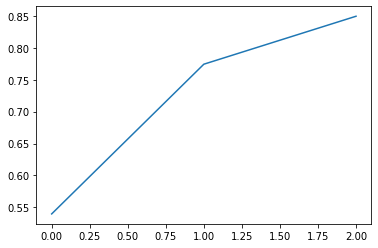

In [19]:
accuracies=[0.5396,0.7744,0.8496]
plt.plot(accuracies)
plt.show()

## Without Feature Extractor

### Train (10 points)

Now also add feature extractor network to your meta-network and repeat the same procedure like above cells just for inner loop update = 1.


In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#################################################################################
#                  COMPLETE THE FOLLOWING SECTION (10 points)                   #
#################################################################################
# Define your config and initialize model and parameters
# prepare your data as input to your model.
# train meta-network
# get acurracy of model in meta-test phase
#################################################################################

inner_loop_update = 1


config = [
        ('conv2d', [64, 1, 3, 3, 1, 1]),
        ('bn', [64]),
        ('relu', [True]),
        ('max_pool2d', [2,2,0]),
        ('conv2d', [64, 64, 3, 3, 1, 1]),
        ('bn', [64]),
        ('relu', [True]),
        ('max_pool2d', [2,2,0]),
        ('conv2d', [64, 64, 3, 3, 1, 1]),
        ('bn', [64]),
        ('relu', [True]),
        ('max_pool2d', [2,2,0]),
        ('conv2d', [64, 64, 3, 3, 1, 1]),
        ('bn', [64]),
        ('relu', [True]),
        ('max_pool2d', [2,2,0]),
        ('flatten', []),
        ('linear', [N, 64])
    ]



device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
epochs = 2000


maml = Meta(config=config,fe=False,update_lr=meta_inner_lr,meta_lr=meta_outer_lr,n_way=N,
            k_spt=support_size,k_qry=query_size,update_step=inner_loop_update,update_step_test=inner_loop_update,device=device).to(device)

tmp = filter(lambda x: x.requires_grad, maml.parameters())
num = sum(map(lambda x: np.prod(x.shape), tmp))
print(maml)
print('Total trainable tensors:', num)


for step in range(epochs+1):

    x,y = iter(train_dataloader).next()

    x_spt = np.empty(shape=(batch_size,N*support_size,1,28,28))
    x_qry = np.empty(shape=(batch_size,N*query_size,1,28,28))
    y_spt = np.empty(shape=(batch_size,N*support_size))
    y_qry = np.empty(shape=(batch_size,N*query_size))
    map_y_spt = np.empty(shape=(batch_size,N*support_size))
    map_y_qry = np.empty(shape=(batch_size,N*query_size))

    num = (support_size+query_size)*N

    for i in range(batch_size):
      x_spt[i]=x[i*(num):i*(num)+support_size*N]
      x_qry[i]=x[i*(num)+support_size*N:(i+1)*(num)]
      y_spt[i]=y[i*(num):i*(num)+support_size*N]
      y_qry[i]=y[i*(num)+support_size*N:(i+1)*(num)]
      map_y_spt[i] = map_labels(torch.from_numpy(y_spt[i]),N*support_size)
      map_y_qry[i] = map_labels(torch.from_numpy(y_qry[i]),N*query_size)
    x_spt, y_spt, x_qry, y_qry = torch.from_numpy(x_spt).to(device,dtype=torch.float), torch.from_numpy(y_spt).type(torch.LongTensor).to(device), \
                                        torch.from_numpy(x_qry).to(device,dtype=torch.float), torch.from_numpy(y_qry).type(torch.LongTensor).to(device)
    


    map_y_spt = torch.from_numpy(map_y_spt).type(torch.LongTensor).to(device)
    map_y_qry = torch.from_numpy(map_y_qry).type(torch.LongTensor).to(device)

    accs = maml(x_spt, map_y_spt, x_qry, map_y_qry)
    with open('/content/drive/MyDrive/MSC1400_1/AML/HW2/Practical/metatrain_4_acc.pickle', 'wb') as handle:
        pickle.dump(accs, handle, protocol=pickle.HIGHEST_PROTOCOL)

    if step % 50 == 0:
            print('step:', step, '\ttraining acc:', accs[-1])

    if step % 500 == 0:
            accs = []
            for _ in range(1000//batch_size):
              # test
              x,y = iter(test_dataloader).next()

              x_spt = np.empty(shape=(batch_size,N*support_size,1,28,28))
              x_qry = np.empty(shape=(batch_size,N*query_size,1,28,28))
              y_spt = np.empty(shape=(batch_size,N*support_size))
              y_qry = np.empty(shape=(batch_size,N*query_size))
              map_y_spt = np.empty(shape=(batch_size,N*support_size))
              map_y_qry = np.empty(shape=(batch_size,N*query_size))
              num = (support_size+query_size)*N

              for i in range(batch_size):
                x_spt[i]=x[i*(num):i*(num)+support_size*N]
                x_qry[i]=x[i*(num)+support_size*N:(i+1)*(num)]
                y_spt[i]=y[i*(num):i*(num)+support_size*N]
                y_qry[i]=y[i*(num)+support_size*N:(i+1)*(num)]
                map_y_spt[i] = map_labels(y_spt[i],N*support_size)
                map_y_qry[i] = map_labels(y_qry[i],N*query_size)
              x_spt, y_spt, x_qry, y_qry = torch.from_numpy(x_spt).to(device,dtype=torch.float), torch.from_numpy(y_spt).type(torch.LongTensor).to(device), \
                                        torch.from_numpy(x_qry).to(device,dtype=torch.float), torch.from_numpy(y_qry).type(torch.LongTensor).to(device)
    
              map_y_spt = torch.from_numpy(map_y_spt).type(torch.LongTensor).to(device)
              map_y_qry = torch.from_numpy(map_y_qry).type(torch.LongTensor).to(device)
              for x_spt_one, y_spt_one, x_qry_one, y_qry_one in zip(x_spt, map_y_spt, x_qry, map_y_qry):
                    test_acc = maml.finetunning(x_spt_one, y_spt_one, x_qry_one, y_qry_one)
                    accs.append( test_acc )

            accs = np.array(accs).mean(axis=0).astype(np.float16)
            with open('/content/drive/MyDrive/MSC1400_1/AML/HW2/Practical/metatest_4_acc.pickle', 'wb') as handle:
                pickle.dump(accs, handle, protocol=pickle.HIGHEST_PROTOCOL)

            print('Test acc:', accs[-1])

#################################################################################
#                                   THE END                                     #
#################################################################################


Meta(
  (net): Learner(
    (vars): ParameterList(
        (0): Parameter containing: [torch.cuda.FloatTensor of size 64x1x3x3 (GPU 0)]
        (1): Parameter containing: [torch.cuda.FloatTensor of size 64 (GPU 0)]
        (2): Parameter containing: [torch.cuda.FloatTensor of size 64 (GPU 0)]
        (3): Parameter containing: [torch.cuda.FloatTensor of size 64 (GPU 0)]
        (4): Parameter containing: [torch.cuda.FloatTensor of size 64x64x3x3 (GPU 0)]
        (5): Parameter containing: [torch.cuda.FloatTensor of size 64 (GPU 0)]
        (6): Parameter containing: [torch.cuda.FloatTensor of size 64 (GPU 0)]
        (7): Parameter containing: [torch.cuda.FloatTensor of size 64 (GPU 0)]
        (8): Parameter containing: [torch.cuda.FloatTensor of size 64x64x3x3 (GPU 0)]
        (9): Parameter containing: [torch.cuda.FloatTensor of size 64 (GPU 0)]
        (10): Parameter containing: [torch.cuda.FloatTensor of size 64 (GPU 0)]
        (11): Parameter containing: [torch.cuda.FloatTensor

### Report (2.5 points)

Report accuracy of meta-test phase.

با توجه به نتایچ بالا می بینیم که در بهترین حالت دقت فاز متاتست 0.2588 شده است.

## Compare and explain Results

Answer:

<br>

همان طور که در این دو قسمت مشاهده کردیم زمانی که از مدل پری ترین شده برای استخراج ویژگی استفاده شد و متاپارامترها فقط لایه آخر بودند نتایج نسبت به حالت آخر که کل شبکه متا پارامترها بودند بهتر بود. با توجه به این که تعداد پارامترهایی که باید ترین می شدند افزایش یافته بود و با تعداد ایپاک یکسان نتایج مقایسه می شوند طبیعی است که مدلی که از خروجی مدل پری ترین شده استفاده می کرد نتایج بهتری داشته باشد. به علاوه عملکرد مدل در حالت اول نیز با افزایش تعداد حلقه های درونی بهبود می یافت چرا که پارامترهای خاص تسک با افزایش تعداد تکرار حلقه داخلی بهتر میشوند به همین دلیل می توان گفت باعث بهبود یادکیری متاپارامترها نیز می شوند تا در مواجهه با تسک های جدید قابلیت یادگیری بیشتری داشته باشند.

